# Iterativne metode

## Minimalne ploskve s konjugiranimi gradienti
Vrnimo se k enačbam za minimalno ploskev na kvadratni mreži. Enačbe za vrednosti $F_{ij} = F(x_j,y_i)$ se glasijo

$$ F_{ij+1}+F_{i+1j}-4F_{ij}+F_{ij-1}+F_{i-1j} = 0$$

S preprosto ureditvijo dobimo enostavno iteracijsko formulo (Jacobijeva iteracija)

$$ F_ij = \frac{1}{4}\left(F_{ij+1}+F_{i+1j}+F_{ij-1}+F_{i-1j}\right), $$

ki jo lahko zelo preprosto implementiramo.


In [13]:
%load  milnica_jakobi.m

In [ ]:
function [X,i] = milnica_jacobi(X0,tol,maxit)
% Funkcija [X,i] = milnica_jacobi(X0) poišče približek za milnico
%  s pomočjo Jakobijeve iteracije
idx = find(X0);
[n,m] = size(X0);
Xp = X0;
X = Xp;
for i=1:maxit
    X(2:n-1,2:m-1) = (Xp(1:n-2,2:m-1) + Xp(3:n,2:m-1) + Xp(2:n-1,1:m-2) + Xp(2:n-1,3:m))/4;
    if max(max(abs(X-Xp))) < tol
       break
    end
    Xp = X;
    Xp(idx) = X0(idx);
end
X = Xp;


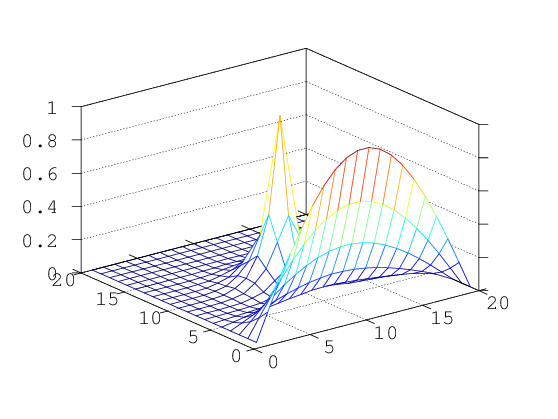

In [11]:
X0 = zeros(20);
X0(1,:) = sin(linspace(0,pi,20));
X0(10,10)=1;
[X,i] = milnica_jakobi(X0,1e-6,10);
mesh(X)

In [12]:
i

i =  10


# Metoda konjugiranih gradientov
Malce bolj komplicirana je metoda konjugiranih gradientov. Zato je ne bomo implementirali, ampak si bomo pogledali, kako jo lahko uporabimo, ne da bi nam bilo treba napisati matriko sistema.


In [16]:
%help pcg

In [17]:
%load milnica_CG.m

In [ ]:
function [X,i] = milnica_CG(X0,tol,maxit)
% Funkcija [X,i] = milnica_CG(X0) poišče približek za milnico
%  s pomočjo Jakobijeve iteracije
idx = find(X0);
[n,m] = size(X0);
N = n*m;
idx0 = setdiff(1:N,idx); % ničelni elti v X0

b = -AkratX(X0,n,m,1:N)(idx0);
Axhandle = @(x) AkratX(x,n,m,idx0);
[x, flag, relres, i] = pcg(Axhandle,b,tol,maxit);
X = X0;
X(idx0) = x;

function b = AkratX(x,n,m,idx)
  X = zeros(n,m);
  X(idx) = x; % make it a matrix
  X(2:n-1,2:m-1) = 4*X(2:n-1,2:m-1) - (X(1:n-2,2:m-1) + X(3:n,2:m-1) + X(2:n-1,1:m-2) + X(2:n-1,3:m));
  b = X(idx);
endfunction


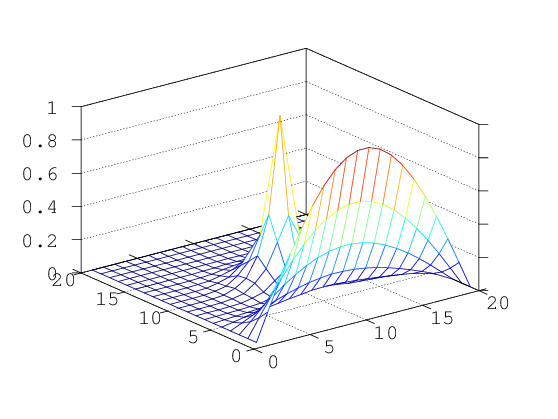

In [18]:
X0 = zeros(20);
X0(1,:) = sin(linspace(0,pi,20));
X0(10,10)=1;
[X,i] = milnica_CG(X0,1e-6,10);
mesh(X)

In [19]:
i

i =  10


# Fizikalna metoda za risanje grafov
Ogledali si bomo metodo za risanje grafov, ki temelji na fizikalnem modelu. Zamislimo si, da je vsaka povezava v grafu  idealna vzmet z elastično energijo

$$\frac{1}{2}k_{ij}\|\mathbf{x_i}-\mathbf{x_j}\|^2,$$

kjer so $\mathbf{x_i}$ in $\mathbf{x_j}$ koordinate vozlišč $i$ in $j$. Nekatere točke fiksiramo, za ostale pa bi radi poiskali položaj, pri katerih bodo vzmeti v ravnovesju. Ravnovesna lega je lega, pri kateri je energija vseh vzmeti minimalna

$$E = \frac{1}{2}\sum_{i,j}k_{ij}\|\mathbf{x_i}-\mathbf{x_j}\|^2.$$

In [46]:
%load vlozi_graf.m

In [ ]:
function [x,y] = vlozi_graf(G,idx0,x0,y0)
% Funkcija [x,y] = vlozi_graf(G,idx) poišče vložitev grafa G v R^2
% z minimalno elastično energijo.
% G ... adjunkcijska matrika grafa G. g(i,j) je koeficient vzmeti
% idx0 ... indeksi fiksnih točk
% x0,y0 ... koordinate fiksnih točk
n = length(G);
idx = setdiff(1:n,idx0); % indeksi ostalih točk
A = G(idx,idx);
A = -A + diag(sum(G(:,idx)));
bx = reshape(x0,1,length(x0))*G(idx0,idx); % fiksne točke prispevajo desne strani enačb
by = reshape(y0,1,length(y0))*G(idx0,idx);

x = zeros(n,1);
y = x;
[x(idx), flag, relres, iter, resvec, eigtest]  = pcg(A,bx',1e-3);
y(idx) = pcg(A,by',1e-6);
x(idx0) = x0;
y(idx0) = y0;


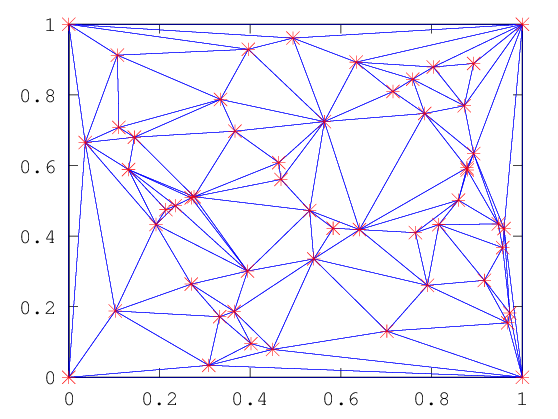

In [42]:
x0 = [0 0 1 1]';
y0 = [0 1 1 0]';
xy = [[x0 y0]; rand(50,2)];
delaunay(xy)

In [43]:
% sestavimo graf
T = delaunay(xy);
i = reshape(T,1,prod(size(T)));
j = reshape(T(:,[2 3 1]),1,prod(size(T)));
G  = sparse(i,j,1);
G = G + G';
G(find(G)) = 1; % vse povezave imajo enako utež

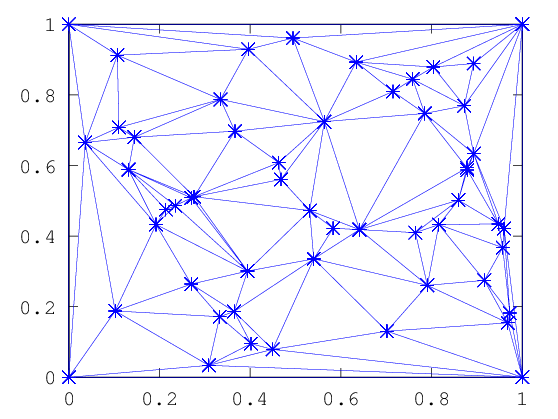

In [44]:
gplot(G,xy,'*-')

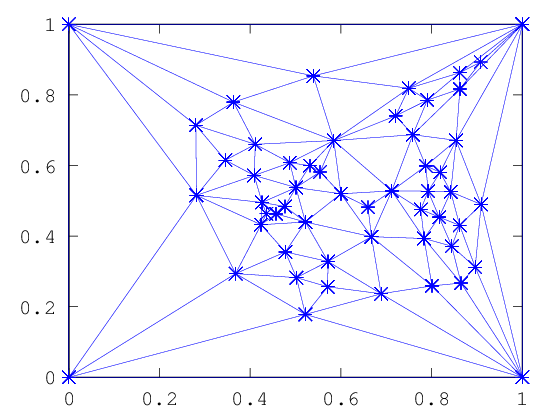

In [45]:
[x,y] = vlozi_graf(G,1:4,x0,y0);
gplot(G,[x y],'*-')

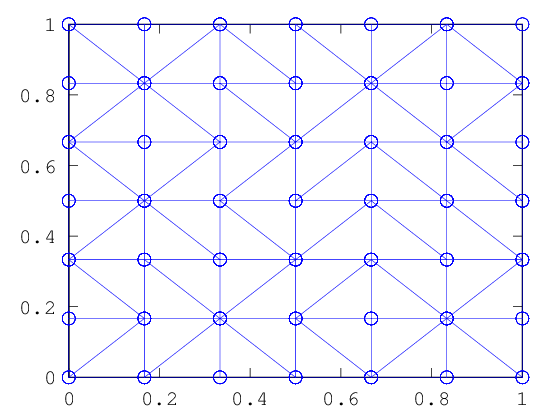

In [47]:
x =  linspace (0,1,7);
[xx,yy] = meshgrid(x,x);
T  = delaunay(xx,yy);
idx = find(xx==0 | xx==1 | yy==0 | yy==1); % rob kvadrata
i = reshape(T,1,prod(size(T))); j = reshape(T(:,[2 3 1]),1,prod(size(T)));
G = sparse(i,j,1); G = G + G'; G(find(G))=1;
xy = [reshape(xx,prod(size(xx)),1) reshape(yy,prod(size(yy)),1)];
gplot(G,xy,'o-')

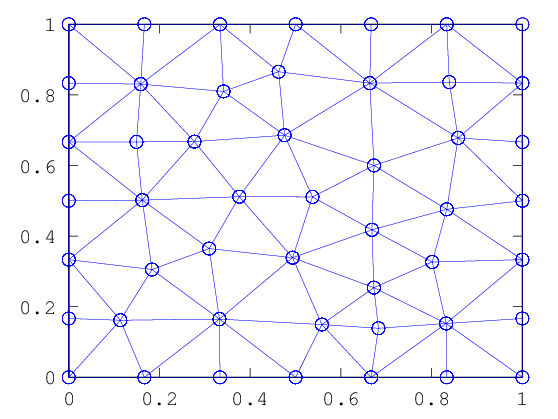

In [48]:
[x,y] = vlozi_graf(G,idx,xx(idx),yy(idx));
gplot(G,[x y],'o-')